# CometTS_Visualizer
CometTS will run through and calculate the statistical central tendencies and amount of statistical spread present in the data over time. It will then plot this data and apply regression lines to it. Additionally, tabular data in a .csv format will be output in the same folder that contains your raster data.

In [1]:
#Imports
import os
from CometTS.CometTS import run_comet
from CometTS.Plotting import run_plot, run_plot_arima
from CometTS.ARIMA import run_arima, timeseries_trend
import ipywidgets as widgets
from IPython.display import Javascript, display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import pandas as pd
import geopandas as gpd
sns.set(color_codes=True)

## Define default paths for sample data
input_path=os.path.abspath('')
input_path=os.path.join(input_path.split("Notebooks")[0],"CometTS/VIIRS_Sample")

## Create your polygons
After the raster data are organized appropriately, you are ready to begin a workflow. The secondary input is simply a polygon vector file which will direct your analysis and calculate the relevant statistics and plots. Polygons can be created in QGIS, the GIS software of your choice, or can be done online. One such way is going to  http://geojson.io/ and using the tool. Ensure that the polygon is in the same projection as your raster data! Otherwise it will appear the data are not overlapping and no statistics will be calculated!

## Some notes on VIIRS Nighttime Lights Imagery

The example workflow continues below with default inputs including NPP VIIRS Nighttime lights monthly composite data and a polygon over San Juan, Puerto Rico.  VIIRS monthly composite data has two bands that can be useful for time series analysis. The first documents the night-time brightness on the ground (S* rade9.tif) and the second documents the number of observations that contribute to each monthly composite (S* cvg.tif). The observation band can be used to plot the number of observations AND as a mask band. If there are 0 observations in a pixel for a month, that does not mean that brightness is 0, simply that there are no observations typically due to cloud cover. As such, these data should be masked out.

## Initialize functions below for plotting, then scroll down to enter your inputs

When your paths are set, click the “Execute…” button. This will then create the relevant statistics over time by iterating through your rasters. The amount of time this will take will depending upon the number of rasters and different AOIs you are analyzing at one time.

In [4]:
# Create text widget for input
def f(z):
    return z

print("Enter csv as created by CSV_Creator(ex: /Raster_List.csv)")
try:
    directory_csv
except NameError:
    directory_csv = interactive(f, z=os.path.join(input_path,'Raster_List.csv'))
    display(directory_csv)
else:
    directory_csv = str(directory_csv.children[0].value)
    directory_csv = interactive(f, z=directory_csv)
    display(directory_csv)

print("Enter full path to vector polygon(ex: /NiameyPoly.shp)")
try:
    zonalpoly
except NameError:
    zonalpoly = interactive(f, z=os.path.join(input_path,'San_Juan.shp'))
    display(zonalpoly)
else:
    zonalpoly = str(zonalpoly.children[0].value)
    zonalpoly = interactive(f, z=zonalpoly)
    display(zonalpoly)

print("Enter NoData Value for null space in imagery(ex: Landsat typically -9999, VIIRS Monthly Composites -1)")
try:
    NoDataValue
except NameError:
    NoDataValue = interactive(f, z='-1')
    display(NoDataValue)
else:
    NoDataValue = str(NoDataValue.children[0].value)
    NoDataValue = interactive(f, z=NoDataValue)
    display(NoDataValue)

print("Enter mask pixel value(s).  (ex: Clouds/Cloud Shadow=1)")
print("If multiple values seperate with a comma, if no masking is required, leave blank")
try:
    mask_value
except NameError:
    mask_value = interactive(f, z='0')
    display(mask_value)
else:
    mask_value = str(mask_value.children[0].value)
    mask_value = interactive(f, z=mask_value)
    display(mask_value)


def run_all(ev):
    I = run_comet(
        directory_csv.children[0].value.strip(),
        zonalpoly.children[0].value.strip(),
        NoDataValue.children[0].value.strip(),
        mask_value.children[0].value.strip(),
        maskit=checkbox.value)
    %matplotlib inline
    run_plot(I)


checkbox = widgets.Checkbox(
    value=True,
    description='Mask Rasters',
    disabled=False
)


button = widgets.Button(description="Execute...")
button.on_click(run_all)
display(checkbox)
display(button)

Enter csv as created by CSV_Creator(ex: /Raster_List.csv)


interactive(children=(Text(value='C:\\Users\\dante\\Documents\\Mun\\CMSC6950\\CometTS\\CometTS/VIIRS_Sample\\R…

Enter full path to vector polygon(ex: /NiameyPoly.shp)


interactive(children=(Text(value='C:\\Users\\dante\\Documents\\Mun\\CMSC6950\\CometTS\\CometTS/VIIRS_Sample\\S…

Enter NoData Value for null space in imagery(ex: Landsat typically -9999, VIIRS Monthly Composites -1)


interactive(children=(Text(value='-1', description='z'), Output()), _dom_classes=('widget-interact',))

Enter mask pixel value(s).  (ex: Clouds/Cloud Shadow=1)
If multiple values seperate with a comma, if no masking is required, leave blank


interactive(children=(Text(value='0', description='z'), Output()), _dom_classes=('widget-interact',))

Checkbox(value=True, description='Mask Rasters')

Button(description='Execute...', style=ButtonStyle())

C:\Users\dante\Documents\Mun\CMSC6950\CometTS\CometTS/VIIRS_Sample\San_Juan.shp
Processing...


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 95.42it/s]


Getting number of observations...


100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 105.96it/s]


Producing csv output...
CSV statistics saved here:  C:\Users\dante\Documents\Mun\CMSC6950\CometTS\CometTS\VIIRS_Sample\VIIRS_Sample\San_Juan_FullStats.csv


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dante\\Documents\\Mun\\CMSC6950\\CometTS\\CometTS\\VIIRS_Sample\\VIIRS_Sample\\San_Juan_FullStats.csv'

## ARIMA Analysis
CometTS has expanded its functionality and now uses auto-regressive integrated moving average (ARIMA) analysis to detect anomalies in a time-series of data.  We have a built in function to calculate this for you automatically.  If you choose to continue with the example workflow, you may recall that Hurricane Maria hit Puerto Rico in September of 2017.  We can track where the expected brightness levels should have been had the hurricane not hit.  

Once initializing the functions and running the commands below we display the mean observed brightness level in San Juan in black and red dots, the number of observations caputured by the VIIRS satellite for the month in blue, and a few forecasts.  The forecasts use any observations before 8-15-2017 to calulate trends using ARIMA and linear analysis, and then apply these forecasts after this date to display where we expect brightness levels to be.  We then calculate the mean absolute error from the ARIMA trend before our date in question (8/15/2017) and multiply it by two to extend our error bars a bit (dark grey area).  We then can automatically flag observations as anamolies (red) if areas are brighter or darker than they should be. 

Enter csv as output by CometTS(ex: /San_Juan_FullStats.csv)


interactive(children=(Text(value='C:\\Users\\dante\\Documents\\Mun\\CMSC6950\\CometTS\\CometTS/VIIRS_Sample\\S…

Enter the output path for all ARIMA statistics (ex: /San_Juan_FullStats_ARIMA.csv)


interactive(children=(Text(value='C:\\Users\\dante\\Documents\\Mun\\CMSC6950\\CometTS\\CometTS/VIIRS_Sample\\S…

Enter the centered moving average amount (typically 3, 5, or a larger odd number)


interactive(children=(Text(value='3', description='z'), Output()), _dom_classes=('widget-interact',))

Enter the cutoff date before or after a significant event in history.  If no event exists, use the final date in the time series. Format is YYYY/MM/DD.


interactive(children=(Text(value='2017/08/15', description='z'), Output()), _dom_classes=('widget-interact',))

Enter an uncertainty multiplier.  The mean absolute error of the ARIMA model vs. your data before the cutoff date will be used to set error bars and flag anomalies.  The uncertainty value is multipled by the MAE value to produce wider or tighter error bounds.


interactive(children=(Text(value='3', description='z'), Output()), _dom_classes=('widget-interact',))

Button(description='Execute...', style=ButtonStyle())

Calculating...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Plotting...


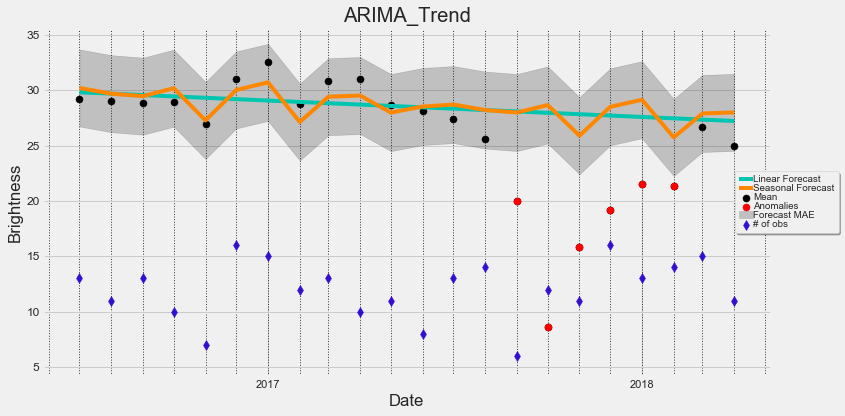

In [3]:
print("Enter csv as output by CometTS(ex: /San_Juan_FullStats.csv)")
try:
    comet_csv
except NameError:
    comet_csv = interactive(f, z=os.path.join(input_path,'San_Juan_FullStats.csv'))
    display(comet_csv)
else:
    comet_csv = str(comet_csv.children[0].value)
    comet_csv = interactive(f, z=comet_csv)
    display(comet_csv)

print("Enter the output path for all ARIMA statistics (ex: /San_Juan_FullStats_ARIMA.csv)")
try:
    arima_output
except NameError:
    arima_output = interactive(f, z=os.path.join(input_path,'San_Juan_FullStats_ARIMA.csv'))
    display(arima_output)
else:
    arima_output = str(arima_output.children[0].value)
    arima_output = interactive(f, z=arima_output)
    display(arima_output)

print("Enter the centered moving average amount (typically 3, 5, or a larger odd number)")
try:
    CMA
except NameError:
    CMA = interactive(f, z='3')
    display(CMA)
else:
    CMA = str(CMA.children[0].value)
    CMA = interactive(f, z=CMA)
    display(CMA)

print("Enter the cutoff date before or after a significant event in history.  If no event exists, use the final date in the time series. Format is YYYY/MM/DD.")
try:
    Cutoff_Date
except NameError:
    Cutoff_Date = interactive(f, z="2017/08/15")
    display(Cutoff_Date)
else:
    Cutoff_Date = str(Cutoff_Date.children[0].value)
    Cutoff_Date = interactive(f, z=Cutoff_Date)
    display(Cutoff_Date)

    
print("Enter an uncertainty multiplier.  The mean absolute error of the ARIMA model vs. your data before the cutoff date will be used to set error bars and flag anomalies.  The uncertainty value is multipled by the MAE value to produce wider or tighter error bounds.")
try:
    Uncertainty
except NameError:
    Uncertainty = interactive(f, z='3')
    display(Uncertainty)
else:
    Uncertainty = str(Uncertainty.children[0].value)
    Uncertainty = interactive(f, z=Uncertainty)
    display(Uncertainty)
    
def gen_plots(input_csv):
    df = pd.read_csv(input_csv)
    df = df.sort_values(['date'])
    geometry = df['geometry'].map(shapely.wkt.loads)
    crs = {'init': 'epsg:2263'}
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    gdf['date'] = pd.to_datetime(gdf['date'], infer_datetime_format=True)
    # run_plot(gdf, y_label="NDVI", title_label= "NDVI over time - ID: ")
    run_plot_arima(gdf)  

def arima_time(ev):
    run_arima(
        comet_csv.children[0].value.strip(),
        arima_output.children[0].value.strip(),
        int(CMA.children[0].value.strip()),
        Cutoff_Date.children[0].value.strip(),
        float(Uncertainty.children[0].value.strip()))
    %matplotlib inline
    gen_plots(arima_output.children[0].value.strip())


checkbox = widgets.Checkbox(
    value=True,
    description='Mask Rasters',
    disabled=False
)


button = widgets.Button(description="Execute...")
button.on_click(arima_time)
display(button)